# Specify Cuda Device

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# import warnings; warnings.simplefilter('ignore')

# Import Library

In [2]:

from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
import sys
import os
import string, nltk
#nltk.download('stopwords')
nltk.data.path.append("/home/ubuntu/nltk_data")
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
#nltk.download('punkt')
#nltk.download('wordnet')
import numpy as np
import torch
from string import punctuation
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
from torchinfo import summary
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt


# Load Global variable and Embedding

Use Pretrain Embedding from Glove, at this report, I use two pretrain glove with 100 and 300 dimention

In [3]:
seqence_len = 150
embed_len = 300
batch_size = 512
Vocab = []
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english') + list(string.punctuation)) 

glove = pd.read_csv("../../wordEmbedding/"+'glove.6B.'+str(embed_len)+'d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

# Utils Functions

Create Embedding matrix from pretrain
- By using pretrain Glove, for each word, we map it to a representative vector

Normalization the input text:
- All  stopwords  and  punctuations  are  filter  out
- With  lemmatization,  a  word  returns  an  actual  word  of  thelanguage. It reduces the inflected words properly ensuring thatthe  root  word  belongs  to  the  language

Padding Text
- To let all input sentences have the same length, so that we can train in each batch

In [4]:
def create_embedding_matrix(word_index,embedding_dict,dimension):
    embedding_matrix=np.zeros((len(word_index)+1,dimension))

    for word,index in word_index.items():
        if word in embedding_dict:
            embedding_matrix[index]=embedding_dict[word]
    return embedding_matrix


def Norm(text,wordnet_lemmatizer,stop_words):
    text = text.lower().strip()
    text =  re.sub(' +', ' ', text)
    word_tokens = word_tokenize(text) 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            w = wordnet_lemmatizer.lemmatize(w, pos="v")
            filtered_sentence.append(w) 
    texts=" ".join(str(x) for x in filtered_sentence)
    return text

def pad_text(encoded_reviews, seq_length):
    
    reviews = []
    
    for review in encoded_reviews:
        print(len(review))
        if len(review) >= seq_length:
            reviews.append(review[:seq_length])
        else:
            reviews.append([0]*(seq_length-len(review)) + review)
        
    return np.array(reviews)

def LoadData(file, Vocab=Vocab):
    with open(file, "r",encoding="ISO-8859-1") as f:
        data_x = []
        data_y = []
        contents = f.read().splitlines()
        for line in contents:
            try:
                _,text,label = line.split("#")
            except:
                continue
            text = text.split(" ",1)[1]
            
            text = "".join([ch for ch in text if ch not in punctuation])
            text = Norm(text,wordnet_lemmatizer,stop_words)
            
            data_x.append(text)
            data_y.append(label)
            Vocab = Vocab + text.split(" ")
        return data_x, data_y, Vocab

# Data Preprocessing

In [5]:
train_x, train_y, Vocab = LoadData("../data/train.txt",Vocab)
dev_x, dev_y, Vocab = LoadData("../data/dev.txt",Vocab)
test_x, test_y, Vocab = LoadData("../data/test.txt",Vocab)
print(test_x[:5])

['sandra bullock and hugh grant make a great team but this predictable romantic comedy should get a pink slip', 'those eternally devoted to the insanity of black will have an intermittently good time feel free to go get popcorn whenever hes not onscreen', 'this is wild surreal stuff but brilliant and the camera just kind of sits there and lets you look at this and its like youre going from one room to the next and none of them have any relation to the other', 'this is a harrowing movie about how parents know where all the buttons are and how to push them', 'without shakespeares eloquent language the update is dreary and sluggish']


### Lenght of sentences distribution

(array([  9.,  50.,  95., 135., 156., 151., 204., 250., 230., 244., 264.,
        295., 300., 299., 354., 356., 357., 333., 351., 292., 321., 298.,
        313., 280., 233., 231., 226., 158., 170., 139., 132.,  94.,  85.,
         78.,  77.,  55.,  48.,  30.,  31.,  25.,  28.,  17.,  10.,  10.,
          4.,   7.,   2.,   2.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <BarContainer object of 48 artists>)

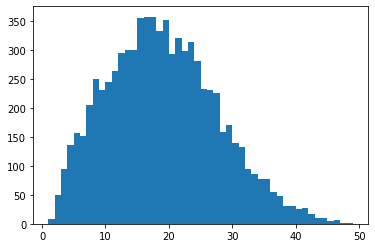

In [6]:
Len_Sentences = [len(x.split()) for x in train_x]
binz = [x for x in range(1,50)]
plt.hist(Len_Sentences, bins=binz)

### Preprocessing data, Setup Dataloader

With this experiment, the data is random load for each batch, do not apply strategy same lenght sentences for each batch

Base on the distribution, the squence_lenght is set to average 100

In [7]:
tokenizer=tf.keras.preprocessing.text.Tokenizer(split=" ")
tokenizer.fit_on_texts(train_x+dev_x+test_x)

encoded_train =tokenizer.texts_to_sequences(train_x)
encoded_dev =tokenizer.texts_to_sequences(dev_x)
encoded_test =tokenizer.texts_to_sequences(test_x)


train_x = pad_text(encoded_train, seq_length = seqence_len)
train_y = np.array([1 if label == "pos" else 0 for label in train_y])


dev_x = pad_text(encoded_dev, seq_length = seqence_len)
dev_y = np.array([1 if label == "pos" else 0 for label in dev_y])


test_x = pad_text(encoded_test, seq_length = seqence_len)
test_y = np.array([1 if label == "pos" else 0 for label in test_y])

# print(len(type(encoded_test)))


train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(dev_x), torch.from_numpy(dev_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

25
25
10
17
17
42
16
17
25
12
6
37
29
23
9
4
17
12
10
21
30
35
19
9
7
13
26
14
30
13
5
23
10
20
25
23
35
24
7
15
9
20
8
21
6
9
17
28
2
26
22
37
7
33
24
12
16
21
15
17
17
8
11
5
21
20
13
24
20
8
31
33
30
23
20
11
17
18
24
27
18
18
28
31
3
23
16
9
23
13
18
23
17
17
14
11
11
31
26
10
46
26
26
23
12
20
24
11
16
20
29
37
37
25
13
12
29
17
17
22
35
32
37
12
24
20
13
17
28
27
36
15
12
19
26
25
6
11
17
26
19
24
24
19
18
17
5
31
3
28
12
21
11
12
16
12
25
7
21
11
19
14
7
25
9
16
12
20
23
16
35
19
23
15
20
9
17
34
27
31
10
40
26
37
19
11
9
14
21
24
11
15
14
36
21
19
13
25
10
4
27
18
26
19
22
24
19
13
21
23
29
4
20
21
25
2
19
9
18
12
5
6
21
24
20
19
17
27
12
15
14
25
22
17
27
10
24
24
10
3
20
13
15
12
14
25
22
24
30
22
15
17
12
6
40
10
26
13
9
33
19
9
18
22
28
12
16
21
16
8
29
11
23
23
22
16
40
17
20
25
13
18
12
15
12
20
12
11
26
36
14
25
15
15
14
26
15
20
23
27
20
10
27
22
12
20
21
9
10
19
13
24
29
17
8
15
17
10
37
19
30
6
14
27
23
24
30
34
9
4
9
22
14
24
12
14
14
10
20
15
16
13
6
22
17
12
12
21


3
7
17
7
12
23
22
30
10
20
28
7
18
33
15
14
31
30
11
5
31
4
33
10
15
25
31
18
22
27
29
22
10
27
8
24
4
20
26
38
17
14
9
23
20
21
10
21
28
19
5
13
7
23
19
8
24
27
25
23
26
9
30
26
12
9
19
21
26
28
12
31
28
16
13
22
17
36
15
15
27
21
12
17
7
8
24
20
3
8
27
11
23
16
15
18
20
16
16
11
19
24
26
18
7
31
29
39
23
2
19
17
25
20
16
7
44
14
28
9
27
24
27
22
20
10
1
9
14
19
23
35
23
26
37
15
28
22
32
31
16
26
18
12
23
28
25
18
12
9
16
12
24
11
12
20
25
20
12
21
21
43
24
11
3
22
11
28
27
23
11
22
23
14
23
18
24
16
22
24
3
14
13
15
6
6
19
29
29
22
5
8
35
15
10
31
13
22
24
27
20
26
8
11
11
41
30
12
22
19
5
15
21
29
10
11
27
28
26
7
32
35
20
15
26
5
23
11
18
28
13
9
25
21
26
10
21
25
38
18
26
29
13
14
4
25
13
32
13
18
16
11
20
29
27
34
4
17
6
4
19
18
26
33
30
8
21
19
9
21
11
20
29
36
15
16
14
16
8
9
17
8
18
12
8
15
14
2
11
14
17
5
21
24
29
25
24
26
12
19
16
12
14
4
16
16
14
9
14
20
12
24
20
23
4
15
6
37
10
24
22
16
31
34
20
13
8
28
14
17
22
6
34
16
5
28
6
13
14
46
19
4
27
34
31
20
24
25
10
10
4
18
12

28
24
25
3
16
23
18
31
32
21
27
1
5
22
16
28
6
28
19
12
23
23
11
21
9
24
13
26
29
18
17
27
20
19
25
6
23
33
21
15
14
19
26
7
17
12
28
21
5
6
25
12
31
9
25
18
14
21
21
21
12
21
16
18
3
19
22
20
6
21
36
14
32
16
17
32
29
8
6
19
17
20
14
36
13
26
6
12
14
20
22
20
27
22
4
31
9
27
34
29
37
20
10
10
29
23
18
9
6
21
20
28
13
19
28
12
15
31
19
16
3
22
8
29
27
24
12
17
24
21
11
23
12
14
15
20
18
15
22
4
8
24
17
33
32
8
7
5
9
3
8
19
31
13
28
29
27
26
17
9
4
16
7
25
22
11
9
18
22
18
20
18
18
5
30
8
21
14
16
17
24
24
22
29
23
19
21
28
24
11
18
16
26
8
12
16
10
24
29
11
18
9
21
9
9
4
25
15
9
10
37
5
13
15
16
6
17
22
13
18
14
32
7
33
24
44
17
38
16
15
23
19
25
26
15
3
33
14
13
5
19
32
9
21
46
21
35
7
6
13
9
34
20
21
11
18
36
25
13
34
15
18
32
37
26
15
20
15
19
16
42
30
21
23
18
10
15
21
16
11
29
19
15
6
4
7
18
23
27
10
15
28
44
24
30
15
8
11
22
18
24
25
30
8
24
28
23
18
3
9
24
12
30
21
28
7
26
14
13
12
6
7
7
5
37
39
17
16
27
8
25
30
15
14
15
10
13
4
38
13
26
9
20
32
3
15
23
17
11
19
31
32
15
15
18
2

In [8]:


embedding_matrix=create_embedding_matrix(tokenizer.word_index,embedding_dict=glove_embedding,dimension=embed_len)

# Models

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### CNN

In [10]:


class CNN(nn.Module):
    
    def __init__(self, n_vocab, n_embed, hidden_node, n_output, layers):
        super().__init__()

        self.embedding = nn.Embedding(n_vocab, n_embed)
        self.seq_len = 150
        self.fc_out = nn.Linear(300, n_output)
        
        self.conv = nn.Conv1d(in_channels=300, out_channels=100,kernel_size=3, padding=1)
        self.conv1 = nn.Conv1d(in_channels=300, out_channels=100,kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=300, out_channels=100,kernel_size=7, padding=3)
        
        self.pooling = nn.MaxPool1d(150)
        
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(0.3)
        
    def forward (self, input_words):                                                        # => (batch size, sent len)

        batch = input_words.shape[0]
        seq_lenght= input_words.size(1)
        
        embedded_words = self.embedding(input_words)                                        # => (batch_size, seq_length, n_embed)
        embedded_words = embedded_words.permute(0,2,1)                                      # => (batch_size,  n_embed,seq_length)
        
        x = self.conv(embedded_words)           #[512, 100, 150]
        x = self.relu(x)
        x = self.pooling(x)                     #[512, 100, 1]
        
        x1 = self.conv1(embedded_words)
        x1 = self.relu(x1)
        x1 = self.pooling(x1)
        
        x2 = self.conv2(embedded_words)
        x2 = self.relu(x2)
        x2 = self.pooling(x2)
        
        
        out = self.fc_out(torch.cat(    (x.squeeze(), x1.squeeze(), x2.squeeze() )  , 1 )            )
        
        sig = self.sigmoid(out)
        return sig, x

# Training

### Hyper-parameter for tuning

In [11]:
n_vocab=embedding_matrix.shape[0]
n_embed=embedding_matrix.shape[1]
n_hidden = 512
n_output = 1   # 1 ("positive") or 0 ("negative")
layers = 1

### Init Training model

In [12]:

net = CNN(n_vocab, n_embed, n_hidden, n_output, layers).cuda()


criterion = nn.BCELoss()
criterion = criterion.cuda()
optimizer = optim.Adam(net.parameters(), lr = 0.0001, weight_decay=0.0001)

print(net)


CNN(
  (embedding): Embedding(20451, 300)
  (fc_out): Linear(in_features=300, out_features=1, bias=True)
  (conv): Conv1d(300, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv1): Conv1d(300, 100, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(300, 100, kernel_size=(7,), stride=(1,), padding=(3,))
  (pooling): MaxPool1d(kernel_size=150, stride=150, padding=0, dilation=1, ceil_mode=False)
  (sigmoid): Sigmoid()
  (relu): ReLU()
  (tanh): Tanh()
  (softmax): Softmax(dim=None)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [13]:
step = 0
n_epochs = 70
clip = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
for epoch in range(n_epochs):
    
    for inputs, labels in train_loader:
        step += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        net.zero_grad()
        output, h = net(inputs)
        loss = criterion(output.squeeze(), labels.float())

        loss.backward()
        
        #To prevent exploding gradients
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()
        
#         if loss.item() < 0.02:
#             break
        
        
        if (step % 50) == 0:            
            net.eval()
            valid_losses = []
            num_val_batch =0 
            for v_inputs, v_labels in valid_loader:
                num_val_batch += 1
                v_inputs, v_labels = v_inputs.to(device), v_labels.to(device)

                
                v_output, v_h = net(v_inputs)
                v_loss = criterion(v_output.squeeze(), v_labels.float())
                valid_losses.append(v_loss.item())
               
            valid_losses = sum(valid_losses)/len(valid_losses)
                
            print("Epoch: {}/{}".format((epoch+1), n_epochs),
                  "Step: {}".format(step),
                  "Training Loss: {:.4f}".format(loss.item()),
                  "Validation Loss: {:.4f}".format(valid_losses),
                 )

            if valid_losses - loss.item() > 0.2:
                break
                
            net.train()
            
#torch.save(net.state_dict(), "LSTM.pt")


cuda


/opt/conda/envs/taco/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch: 4/70 Step: 50 Training Loss: 0.6149 Validation Loss: 0.6584
Epoch: 7/70 Step: 100 Training Loss: 0.5523 Validation Loss: 0.6424
Epoch: 10/70 Step: 150 Training Loss: 0.5044 Validation Loss: 0.6285
Epoch: 13/70 Step: 200 Training Loss: 0.4465 Validation Loss: 0.6189
Epoch: 16/70 Step: 250 Training Loss: 0.3925 Validation Loss: 0.6077
Epoch: 20/70 Step: 300 Training Loss: 0.3497 Validation Loss: 0.6006
Epoch: 24/70 Step: 350 Training Loss: 0.3066 Validation Loss: 0.5935
Epoch: 28/70 Step: 400 Training Loss: 0.2595 Validation Loss: 0.5900
Epoch: 32/70 Step: 450 Training Loss: 0.2318 Validation Loss: 0.5879
Epoch: 36/70 Step: 500 Training Loss: 0.1943 Validation Loss: 0.5810
Epoch: 40/70 Step: 550 Training Loss: 0.1605 Validation Loss: 0.5821
Epoch: 44/70 Step: 600 Training Loss: 0.1493 Validation Loss: 0.5855
Epoch: 48/70 Step: 650 Training Loss: 0.1239 Validation Loss: 0.5814
Epoch: 52/70 Step: 700 Training Loss: 0.1096 Validation Loss: 0.5804
Epoch: 56/70 Step: 750 Training Loss:

# Predict test

In [14]:
net.eval().to(device)
count = 0
sums = 0

for v_inputs, v_labels in test_loader:
    
    sums = sums + len(v_inputs)
    
    v_inputs, v_labels = v_inputs.to(device), v_labels.to(device)

    v_output, v_h = net(v_inputs)
    
    v_loss = criterion(v_output.squeeze(), v_labels.float())
        

    output = torch.round(v_output.squeeze()).detach().cpu().numpy().astype(int)

    ground = v_labels.detach().cpu().numpy().astype(int)

    count = count + np.sum(output == ground)
    
print("Accuracy: " + str(count/len(test_x)))
print(len(test_x))
print(sums)

Accuracy: 0.6828919112383679
1397
1397


# Inference Sample

In [16]:
def inference(net, review, seq_length = 200):
    device = "cuda" #"cuda" if torch.cuda.is_available() else "cpu"
    
    text = review.lower()
    text = "".join([ch for ch in text if ch not in punctuation])
    words = text
    
    encoded_train =tokenizer.texts_to_sequences([words])
    padded_words = pad_text(encoded_train, seq_length = 200)
    padded_words = torch.from_numpy(padded_words).to(device)

    
    net.eval().to(device)
    output, h = net(padded_words )#, h)
    pred = torch.round(output.squeeze())  
    return pred

Test = [
    "It make me happy",
    "Unpleasant viewing experience",
    "I am interested with this assigment",
    "Poor you",
    "Happy new year"
]
for t in Test:
    lab = inference(net, t).tolist()
    if int(lab) == 0:
        print("negative:\t"+t)
    else:
        print("postive:\t"+t)
